# Xgboost Classifier

In [1]:
import sys, os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
from datetime import datetime
import pandas_profiling
from plots import *
from eda import *
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import re
import plotly.graph_objects as go
from plotly.graph_objs import *
from plotly.offline import plot
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split 
import xgboost as xgb
import re
%reload_ext autoreload
%autoreload 2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



## one-hot encoding for categorical columns

In [20]:
df_raw = pd.read_csv('../credits.csv', index_col='ID', low_memory=False, parse_dates=True)
categorical_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'MARRIAGE', 'EDUCATION', 'SEX']

for col in categorical_cols:
    df_raw[col] = df_raw[col].astype('category')
df = df_raw.copy()

## Covert one-hot codes to integer

In [21]:
convert_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
convert_cat_codes(df, convert_cols)

In [24]:
for col in categorical_cols:
    df[col] = df[col].astype('int')

## Train model

In [7]:
data = df.drop(columns=['default payment next month'])
X_train, X_test, Y_train, Y_test = train_test_split(data, df['default payment next month'], test_size=0.3)

param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic'}

In [8]:
dtrain = xgb.DMatrix(data=X_train, label=Y_train)
dtest = xgb.DMatrix(data=X_test, label=Y_test)

* prediction
preds = bst.predict(dtest)
labels = dtest.get_label()
print('error=%f' % (sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) != labels[i]) / float(len(preds))))
bst.save_model('0001.model')
* dump model
bst.dump_model('dump.raw.txt')
* dump model with feature map
bst.dump_model('dump.nice.txt', '/opt/workspace/tmp/featmap.txt')

In [9]:
xgb_classifier = xgb.XGBClassifier(objective ='binary:logistic', num_round = 5, 
                                  colsample_bytree = 1, learning_rate = 0.1, 
                                  max_depth = 5, alpha = 10, n_estimators = 10)

`Parameters`
* learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
* max_depth: determines how deeply each tree is allowed to grow during any boosting round.
* subsample: percentage of samples used per tree. Low value can lead to underfitting.
* colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
* n_estimators: number of trees you want to build.
* objective: determines the loss function to be used like reg:linear for regression problems, reg:logistic for classification problems with only decision, binary:logistic for classification problems with probability.
* XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.

* gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
* alpha: L1 regularization on leaf weights. A large value leads to more regularization.
* lambda: L2 regularization on leaf weights and is smoother than L1 regularization.


In [10]:
xgb_classifier.fit(X_train,np.array(Y_train))
preds = xgb_classifier.predict(X_test)
#labels = dtest.get_label()
rmse = np.sqrt(mean_squared_error(np.array(Y_test), preds))

print('accuracy=%f' % (sum(1 for i in range(len(preds)) if preds[i] == np.array(Y_test)[i]) / len(preds)))
print("RMSE: %f" % (rmse))
xgb_classifier.save_model('xgb_classifier.model')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning:

The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.

/opt/xgboost/python-package/xgboost/sklearn.py:285: Warning:

save_model: Useful attributes in the Python object XGBClassifier will be lost. If you did not mean to export the model to a non-Python binding of XGBoost, consider using `pickle` or `joblib` to save your model.



accuracy=0.819000
RMSE: 0.425441


## Use 5-fold Cross Validation

In [11]:
params = {'objective':'binary:logistic', 'num_round':10, 'colsample_bytree':1, 'learning_rate':0.1, 'max_depth':5, 'alpha':10, 'n_estimators':10}

metrics = ["rmse", "auc", "error"]

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=5,
                    num_boost_round=10, early_stopping_rounds=10, metrics=metrics , as_pandas=True, seed=101)

In [12]:
cv_results.head(10)

,train-rmse-mean,train-rmse-std,train-auc-mean,train-auc-std,train-error-mean,train-error-std,test-rmse-mean,test-rmse-std,test-auc-mean,test-auc-std,test-error-mean,test-error-std
0,0.477916,0.000150,0.752954,0.006992,0.176262,0.001108,0.478231,0.000270,0.745032,0.012516,0.181905,0.004372
1,0.459283,0.000247,0.759567,0.005900,0.176036,0.001088,0.459944,0.000477,0.749093,0.014434,0.181095,0.004368
2,0.443555,0.000347,0.768789,0.004205,0.175619,0.001688,0.444473,0.000637,0.758533,0.007015,0.181095,0.004913
3,0.430291,0.000448,0.770897,0.004760,0.175631,0.001582,0.431487,0.000863,0.760150,0.007003,0.180286,0.005060
4,0.419116,0.000474,0.773205,0.002747,0.175357,0.001080,0.420593,0.001023,0.761679,0.007274,0.179333,0.004635
5,0.409749,0.000541,0.775088,0.003322,0.175405,0.000925,0.411496,0.001193,0.764165,0.005769,0.179905,0.004234
6,0.401968,0.000596,0.775220,0.003158,0.175690,0.001103,0.403961,0.001362,0.764557,0.005616,0.179476,0.003491
7,0.395428,0.000655,0.775981,0.003494,0.175643,0.001164,0.397683,0.001446,0.765249,0.004680,0.179334,0.003587
8,0.389921,0.000656,0.778098,0.003490,0.175762,0.001268,0.392425,0.001598,0.766941,0.004886,0.179667,0.003696
9,0.385353,0.000742,0.779872,0.002625,0.175917,0.001140,0.388083,0.001696,0.768834,0.004474,0.179762,0.003642


In [14]:
import collections
import operator
result = {}
d = xgb_classifier.get_booster().get_score(importance_type='weight')

for item in sorted(d.items(), key=lambda x: x[1], reverse=True):
    result[item[0]] = d[item[0]]

feature_importance_plot(result)

## Draw a tree

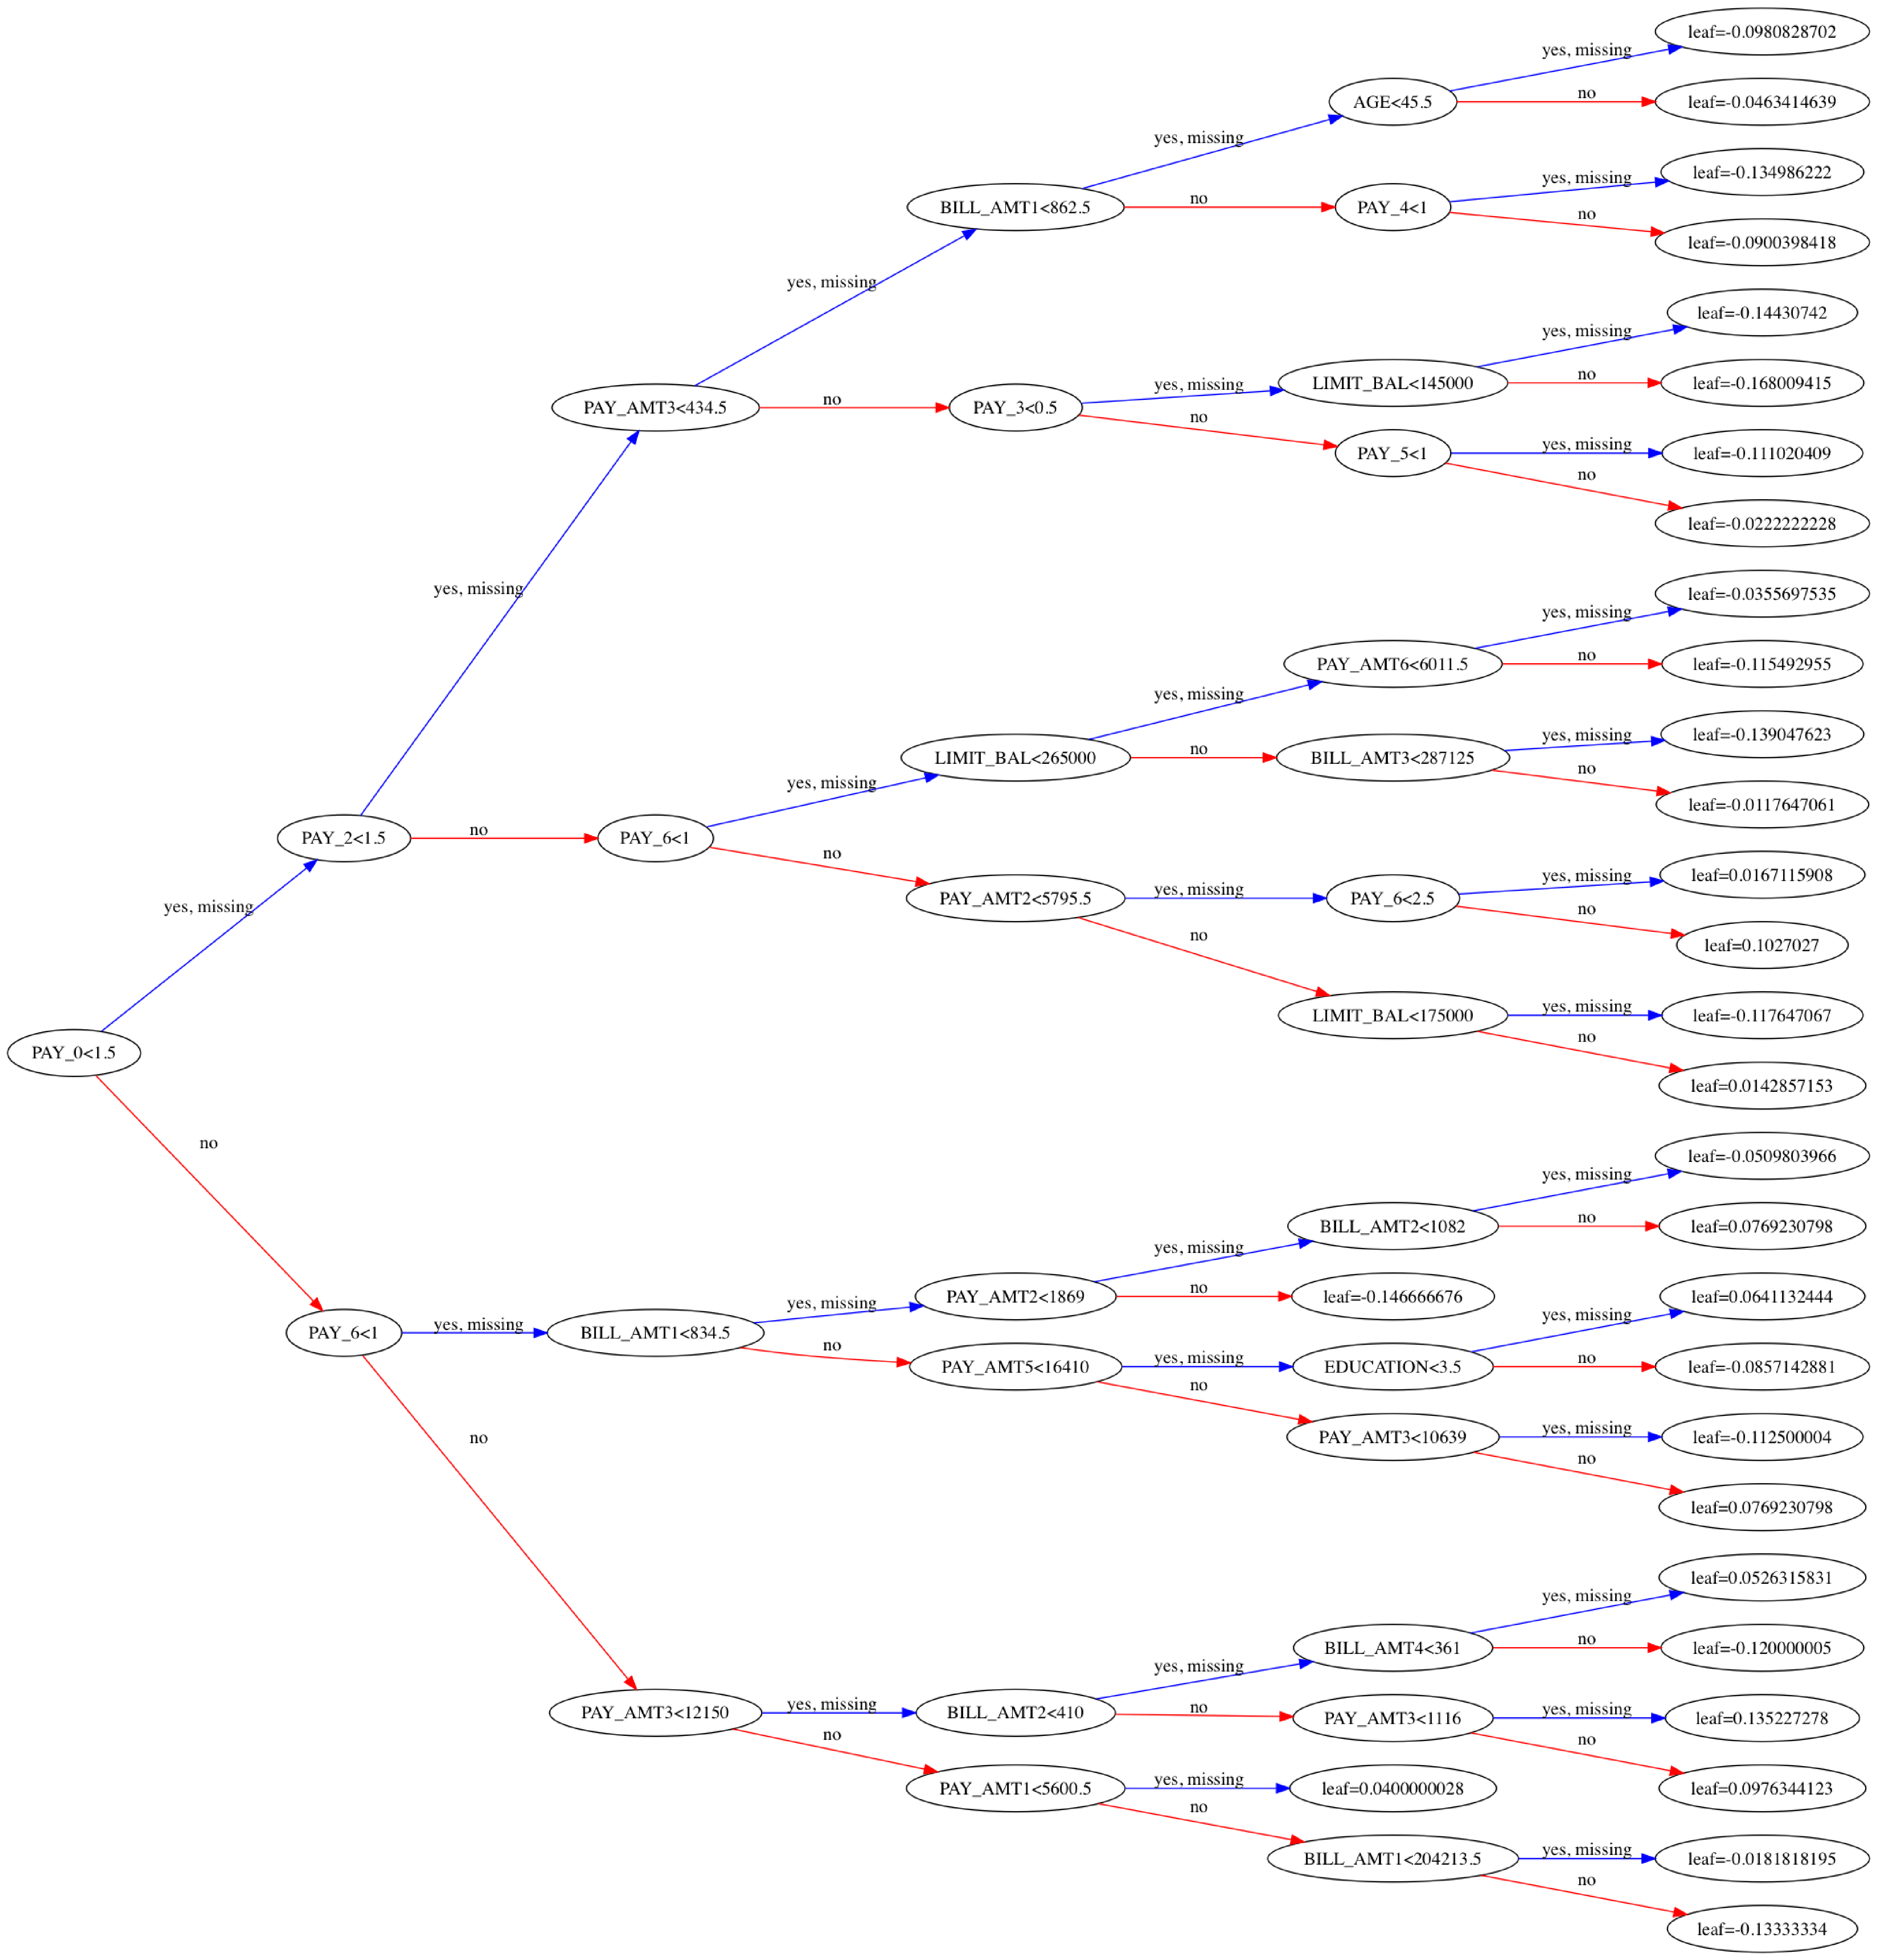

In [19]:
fig, ax = plt.subplots(figsize=(100, 100))
xgb.plot_tree(xgb_classifier,num_trees=0, ax=ax, rankdir='LR')
plt.show()